In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### This notebook was created to (1) convert the genotypes matrix for all isolates into a pairwise SNP distance matrix and (2) compare the SNP differences *within* and *between* lineages

In [3]:
import vcf

%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from itertools import compress
from pylab import MaxNLocator
import seaborn as sns; sns.set()
from matplotlib.colors import LogNorm
from matplotlib import gridspec
import ast
import itertools
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import fastcluster
from sklearn import cluster, datasets
import scipy.cluster.hierarchy as hier
from sklearn.cluster import KMeans
import time
import sys

import Bio
from Bio.Alphabet import IUPAC
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import pairwise2
from Bio import SeqIO
from Bio.Graphics import GenomeDiagram
from Bio.SeqUtils import GC
from Bio import Phylo

from Bio.Align.Applications import MuscleCommandline
from StringIO import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq
import itertools
import gzip
from scipy.sparse import csr_matrix

import networkx as nx
import scipy
from collections import Counter
from itertools import groupby
from operator import itemgetter
import numpy.ma as ma
import time

####################################################################################################################################################################################

## [1] Break up the Genotypes Matrix into several by seperating the isolates into different groups and slicing vertically on the columns

####################################################################################################################################################################################

In [101]:
#load Genotypes Matrix
genotypes_array =  np.load('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_matrix.npy')

In [102]:
genotypes_array

array([[1, 1, 1, ..., 1, 1, 1],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [1, 9, 9, ..., 1, 1, 1],
       [1, 9, 1, ..., 1, 1, 1],
       [1, 9, 1, ..., 1, 1, 1]], dtype=int8)

In [103]:
np.shape(genotypes_array) #782,565 SNP sites & 31,428 isolates

(782565, 31428)

#### Specify the number of groups you're going to break genotypes matrix into & get the boundaries (indices) that break up the columns correspondingly

In [33]:
num_isolate_groups = 10

In [35]:
num_isolates = np.shape(genotypes_array)[1]

#get the indices for the boundaries for the isolate groups
num_isolates_per_group = int( np.floor(float(num_isolates) / float(num_isolate_groups)) ) - 1
remainder_isolates = num_isolates % num_isolate_groups

isolate_index_boundaries_dict = {}
first_index = 0
for isolate_group in range(1 , num_isolate_groups+1):
    
    #if last isolate group, also add the remainder isolates
    if isolate_group != num_isolate_groups:
        isolate_index_boundaries_dict[str(isolate_group)] = [first_index , first_index + num_isolates_per_group]
        
    elif isolate_group == num_isolate_groups:
        isolate_index_boundaries_dict[str(isolate_group)] = [first_index , first_index + num_isolates_per_group + remainder_isolates]
        
    first_index = first_index + num_isolates_per_group + 1
    
isolate_index_boundaries_series = pd.Series(isolate_index_boundaries_dict)

In [36]:
isolate_index_boundaries_series

1          [0, 3141]
10    [28278, 31427]
2       [3142, 6283]
3       [6284, 9425]
4      [9426, 12567]
5     [12568, 15709]
6     [15710, 18851]
7     [18852, 21993]
8     [21994, 25135]
9     [25136, 28277]
dtype: object

#### Split the genotypes matrix vertically according to the boundaries above

In [107]:
#save each sub-matrix seperately
for isolate_group in isolate_index_boundaries_series.index:
    
    first_index_for_group , last_index_for_group = isolate_index_boundaries_series[isolate_group]
    
    genotypes_array_vertical_slice = genotypes_array[: , first_index_for_group:last_index_for_group+1]
    
    #save as a numpy pickle
    np.save('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/pairwise_distance_matrix/vertically_sliced_genotypes_matrix/genotypes_matrix_' + isolate_group , genotypes_array_vertical_slice , allow_pickle = True)

#### Since pairwise *similarity* matrices and pairwise *distance* matrices are symmetric, find out which sub-matrix pairs we have to multiply 

In [37]:
#this matrix holds the matrix multiplications we have to carry out for the sub-matrices to recover the entire matrix that would result from using the full genotypes matrix in the matrix multiplications
submatrix_comparison_array = np.zeros([num_isolate_groups,num_isolate_groups] , dtype = 'object')
submatrix_comparison_array.astype(str)

for isolate_group_i in isolate_index_boundaries_series.index:
    
    for isolate_group_j in isolate_index_boundaries_series.index:
        
        submatrix_comparison_array[int(isolate_group_i)-1 , int(isolate_group_j)-1] = isolate_group_i + 'x' + isolate_group_j

In [40]:
print submatrix_comparison_array

[['1x1' '1x2' '1x3' '1x4' '1x5' '1x6' '1x7' '1x8' '1x9' '1x10']
 ['2x1' '2x2' '2x3' '2x4' '2x5' '2x6' '2x7' '2x8' '2x9' '2x10']
 ['3x1' '3x2' '3x3' '3x4' '3x5' '3x6' '3x7' '3x8' '3x9' '3x10']
 ['4x1' '4x2' '4x3' '4x4' '4x5' '4x6' '4x7' '4x8' '4x9' '4x10']
 ['5x1' '5x2' '5x3' '5x4' '5x5' '5x6' '5x7' '5x8' '5x9' '5x10']
 ['6x1' '6x2' '6x3' '6x4' '6x5' '6x6' '6x7' '6x8' '6x9' '6x10']
 ['7x1' '7x2' '7x3' '7x4' '7x5' '7x6' '7x7' '7x8' '7x9' '7x10']
 ['8x1' '8x2' '8x3' '8x4' '8x5' '8x6' '8x7' '8x8' '8x9' '8x10']
 ['9x1' '9x2' '9x3' '9x4' '9x5' '9x6' '9x7' '9x8' '9x9' '9x10']
 ['10x1' '10x2' '10x3' '10x4' '10x5' '10x6' '10x7' '10x8' '10x9' '10x10']]


In [39]:
submatrix_comparison_array

array([['1x1', '1x2', '1x3', '1x4', '1x5', '1x6', '1x7', '1x8', '1x9',
        '1x10'],
       ['2x1', '2x2', '2x3', '2x4', '2x5', '2x6', '2x7', '2x8', '2x9',
        '2x10'],
       ['3x1', '3x2', '3x3', '3x4', '3x5', '3x6', '3x7', '3x8', '3x9',
        '3x10'],
       ['4x1', '4x2', '4x3', '4x4', '4x5', '4x6', '4x7', '4x8', '4x9',
        '4x10'],
       ['5x1', '5x2', '5x3', '5x4', '5x5', '5x6', '5x7', '5x8', '5x9',
        '5x10'],
       ['6x1', '6x2', '6x3', '6x4', '6x5', '6x6', '6x7', '6x8', '6x9',
        '6x10'],
       ['7x1', '7x2', '7x3', '7x4', '7x5', '7x6', '7x7', '7x8', '7x9',
        '7x10'],
       ['8x1', '8x2', '8x3', '8x4', '8x5', '8x6', '8x7', '8x8', '8x9',
        '8x10'],
       ['9x1', '9x2', '9x3', '9x4', '9x5', '9x6', '9x7', '9x8', '9x9',
        '9x10'],
       ['10x1', '10x2', '10x3', '10x4', '10x5', '10x6', '10x7', '10x8',
        '10x9', '10x10']], dtype=object)

We will carry out the sub-matrix multiplications for the isolate groups in the **upper triangular** part of this matrix

In [110]:
print np.triu(submatrix_comparison_array , k = 0)

[['1x1' '1x2' '1x3' '1x4' '1x5' '1x6' '1x7' '1x8' '1x9' '1x10']
 [0 '2x2' '2x3' '2x4' '2x5' '2x6' '2x7' '2x8' '2x9' '2x10']
 [0 0 '3x3' '3x4' '3x5' '3x6' '3x7' '3x8' '3x9' '3x10']
 [0 0 0 '4x4' '4x5' '4x6' '4x7' '4x8' '4x9' '4x10']
 [0 0 0 0 '5x5' '5x6' '5x7' '5x8' '5x9' '5x10']
 [0 0 0 0 0 '6x6' '6x7' '6x8' '6x9' '6x10']
 [0 0 0 0 0 0 '7x7' '7x8' '7x9' '7x10']
 [0 0 0 0 0 0 0 '8x8' '8x9' '8x10']
 [0 0 0 0 0 0 0 0 '9x9' '9x10']
 [0 0 0 0 0 0 0 0 0 '10x10']]


In [111]:
submatrix_multiplication_pairs_to_multiply = np.triu(submatrix_comparison_array , k = 0).flatten()
submatrix_multiplication_pairs_to_multiply = submatrix_multiplication_pairs_to_multiply[[type(mult_pair)==str for mult_pair in submatrix_multiplication_pairs_to_multiply]]
submatrix_multiplication_pairs_to_multiply = list(submatrix_multiplication_pairs_to_multiply)

In [112]:
print submatrix_multiplication_pairs_to_multiply

['1x1', '1x2', '1x3', '1x4', '1x5', '1x6', '1x7', '1x8', '1x9', '1x10', '2x2', '2x3', '2x4', '2x5', '2x6', '2x7', '2x8', '2x9', '2x10', '3x3', '3x4', '3x5', '3x6', '3x7', '3x8', '3x9', '3x10', '4x4', '4x5', '4x6', '4x7', '4x8', '4x9', '4x10', '5x5', '5x6', '5x7', '5x8', '5x9', '5x10', '6x6', '6x7', '6x8', '6x9', '6x10', '7x7', '7x8', '7x9', '7x10', '8x8', '8x9', '8x10', '9x9', '9x10', '10x10']


The sub-matrix multiplications for the isolate groups in the **lower triangular** part of the matrix aren't necessary since
$$M_jxM_i = (M_ixM_j)^T$$

In [113]:
print np.tril(submatrix_comparison_array , k = -1)

[[0 0 0 0 0 0 0 0 0 0]
 ['2x1' 0 0 0 0 0 0 0 0 0]
 ['3x1' '3x2' 0 0 0 0 0 0 0 0]
 ['4x1' '4x2' '4x3' 0 0 0 0 0 0 0]
 ['5x1' '5x2' '5x3' '5x4' 0 0 0 0 0 0]
 ['6x1' '6x2' '6x3' '6x4' '6x5' 0 0 0 0 0]
 ['7x1' '7x2' '7x3' '7x4' '7x5' '7x6' 0 0 0 0]
 ['8x1' '8x2' '8x3' '8x4' '8x5' '8x6' '8x7' 0 0 0]
 ['9x1' '9x2' '9x3' '9x4' '9x5' '9x6' '9x7' '9x8' 0 0]
 ['10x1' '10x2' '10x3' '10x4' '10x5' '10x6' '10x7' '10x8' '10x9' 0]]


In [114]:
submatrix_multiplication_pairs_inferrred_from_transposing = np.tril(submatrix_comparison_array , k = -1).flatten()
submatrix_multiplication_pairs_inferrred_from_transposing = submatrix_multiplication_pairs_inferrred_from_transposing[[type(mult_pair)==str for mult_pair in submatrix_multiplication_pairs_inferrred_from_transposing]]
submatrix_multiplication_pairs_inferrred_from_transposing = list(submatrix_multiplication_pairs_inferrred_from_transposing)

In [115]:
print submatrix_multiplication_pairs_inferrred_from_transposing

['2x1', '3x1', '3x2', '4x1', '4x2', '4x3', '5x1', '5x2', '5x3', '5x4', '6x1', '6x2', '6x3', '6x4', '6x5', '7x1', '7x2', '7x3', '7x4', '7x5', '7x6', '8x1', '8x2', '8x3', '8x4', '8x5', '8x6', '8x7', '9x1', '9x2', '9x3', '9x4', '9x5', '9x6', '9x7', '9x8', '10x1', '10x2', '10x3', '10x4', '10x5', '10x6', '10x7', '10x8', '10x9']


####################################################################################################################################################################################

## [2] Create a script to construct the pairwise simililarity matrices (for A, C, G and T) and also the matrix that contains the number of non-NA sites called for each pair of isolates (NA).

### *carry out matrix multiplications on the sub-matrices of the genotypes matrix, split vertically by grouping isolates*

####################################################################################################################################################################################

### EXPLAIN METHODOLOGY FOR COMPUTING SIMILARITY MATRICES AND SUBTRACTING FROM NUMBER OF GOOD SITES BETWEEN EACH PAIR

In [118]:
import numpy as np
from scipy.sparse import csr_matrix
import sys
import timeit

In [119]:
#INPUT - condition that turns Genotypes Array into a Boolean (one of five options) ['A','C','G','T','not_NaN']
genotypes_bool_condition = 'A'

#INPUT - which pair of sub-matrices (vertically sliced from full genoyptes matrix) to multiply (A x B^T)
genotypes_submatrix_A = '1'
genotypes_submatrix_B = '3'

#### Check runtime of matrix multiplication to see if runtime is reasonable for the different kinds of binary sub-matrices (A-T are the most sparse while not-NaN are the least sparse)

In [124]:
#for genotypes_bool_condition = 'A'
###########################################################################################################
#necessary setup to test matrix multiplication
code_to_setup = """
import numpy as np
from scipy.sparse import csr_matrix
import sys
import timeit

#load Genotypes Sub-Matrices (pick submatrix 2 & submatrix 5 as an example)
genotypes_array_A =  np.load('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/pairwise_distance_matrix/vertically_sliced_genotypes_matrix/genotypes_matrix_2.npy')
genotypes_array_B =  np.load('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/pairwise_distance_matrix/vertically_sliced_genotypes_matrix/genotypes_matrix_5.npy')

#subset to 32 isolates (31500/10 = 3150 = 31.5*100 = 31.5*10*10) for runtime check, as number of isolates scale by 10x - Runtime scales by 100x (so multiply this runtime by 100*100 = 10,000 to get estimate)
genotypes_array_A = genotypes_array_A[: , 0:32]
genotypes_array_B = genotypes_array_B[: , 0:32]

#convert genotypes matrix A to it's tranpose so that Rows:isolates , Columns:SNP sites to set up for matrix multiplication of (isolate pair i) <-> (isolate pair j) against genotypes matrix B where Rows:SNP sites , Columns:isolates
genotypes_array_A = genotypes_array_A.T

#convert genotypes arrays into a boolean (then to a binary matrix) based off of some condition
Geno_bool_A = genotypes_array_A == 0
Geno_bool_B = genotypes_array_B == 0

#delete Genotypes Matrices from memory
del genotypes_array_A
del genotypes_array_B
    
#convert boolean matrices into a binary matrix to prep for matrix multiplication
Geno_bool_A = Geno_bool_A.astype(int)
Geno_bool_B = Geno_bool_B.astype(int)

#convert binary matrix to a scipy sparse matrix to improve multiplication runtime
Geno_bool_A = csr_matrix(Geno_bool_A)
Geno_bool_B = csr_matrix(Geno_bool_B)
"""

#test runtime of matrix multiplication 
code_to_test = """
#compute similarity matrix by multiplying Genotypes binary matrix for submatrix A by the Genotypes binary matrix for submatrix B
Sim_matrix = Geno_bool_A.dot(Geno_bool_B).toarray()"""

#test the matrix multiplication 3 times and take the average
avg_time_to_multiply_A_T = timeit.timeit(setup = code_to_setup , stmt = code_to_test, number = 3) / 3.0
###########################################################################################################

#for genotypes_bool_condition = 'C'
###########################################################################################################
#necessary setup to test matrix multiplication
code_to_setup = """
import numpy as np
from scipy.sparse import csr_matrix
import sys
import timeit

#load Genotypes Sub-Matrices (pick submatrix 2 & submatrix 5 as an example)
genotypes_array_A =  np.load('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/pairwise_distance_matrix/vertically_sliced_genotypes_matrix/genotypes_matrix_2.npy')
genotypes_array_B =  np.load('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/pairwise_distance_matrix/vertically_sliced_genotypes_matrix/genotypes_matrix_5.npy')

#subset to 32 isolates (31500/10 = 3150 = 31.5*100 = 31.5*10*10) for runtime check, as number of isolates scale by 10x - Runtime scales by 100x (so multiply this runtime by 100*100 = 10,000 to get estimate)
genotypes_array_A = genotypes_array_A[: , 0:32]
genotypes_array_B = genotypes_array_B[: , 0:32]

#convert genotypes matrix A to it's tranpose so that Rows:isolates , Columns:SNP sites to set up for matrix multiplication of (isolate pair i) <-> (isolate pair j) against genotypes matrix B where Rows:SNP sites , Columns:isolates
genotypes_array_A = genotypes_array_A.T

#convert genotypes arrays into a boolean (then to a binary matrix) based off of some condition
Geno_bool_A = genotypes_array_A == 1
Geno_bool_B = genotypes_array_B == 1

#delete Genotypes Matrices from memory
del genotypes_array_A
del genotypes_array_B
    
#convert boolean matrices into a binary matrix to prep for matrix multiplication
Geno_bool_A = Geno_bool_A.astype(int)
Geno_bool_B = Geno_bool_B.astype(int)

#convert binary matrix to a scipy sparse matrix to improve multiplication runtime
Geno_bool_A = csr_matrix(Geno_bool_A)
Geno_bool_B = csr_matrix(Geno_bool_B)
"""

#test runtime of matrix multiplication 
code_to_test = """
#compute similarity matrix by multiplying Genotypes binary matrix for submatrix A by the Genotypes binary matrix for submatrix B
Sim_matrix = Geno_bool_A.dot(Geno_bool_B).toarray()"""

#test the matrix multiplication 3 times and take the average
avg_time_to_multiply_C_G = timeit.timeit(setup = code_to_setup , stmt = code_to_test, number = 3) / 3.0
###########################################################################################################

#for genotypes_bool_condition = 'not_NaN'
###########################################################################################################
#necessary setup to test matrix multiplication
code_to_setup = """
import numpy as np
from scipy.sparse import csr_matrix
import sys
import timeit

#load Genotypes Sub-Matrices (pick submatrix 2 & submatrix 5 as an example)
genotypes_array_A =  np.load('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/pairwise_distance_matrix/vertically_sliced_genotypes_matrix/genotypes_matrix_2.npy')
genotypes_array_B =  np.load('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/pairwise_distance_matrix/vertically_sliced_genotypes_matrix/genotypes_matrix_5.npy')

#subset to 32 isolates (31500/10 = 3150 = 31.5*100 = 31.5*10*10) for runtime check, as number of isolates scale by 10x - Runtime scales by 100x (so multiply this runtime by 100*100 = 10,000 to get estimate)
genotypes_array_A = genotypes_array_A[: , 0:32]
genotypes_array_B = genotypes_array_B[: , 0:32]

#convert genotypes matrix A to it's tranpose so that Rows:isolates , Columns:SNP sites to set up for matrix multiplication of (isolate pair i) <-> (isolate pair j) against genotypes matrix B where Rows:SNP sites , Columns:isolates
genotypes_array_A = genotypes_array_A.T

#convert genotypes arrays into a boolean (then to a binary matrix) based off of some condition
Geno_bool_A = genotypes_array_A != 9
Geno_bool_B = genotypes_array_B != 9

#delete Genotypes Matrices from memory
del genotypes_array_A
del genotypes_array_B
    
#convert boolean matrices into a binary matrix to prep for matrix multiplication
Geno_bool_A = Geno_bool_A.astype(int)
Geno_bool_B = Geno_bool_B.astype(int)

#convert binary matrix to a scipy sparse matrix to improve multiplication runtime
Geno_bool_A = csr_matrix(Geno_bool_A)
Geno_bool_B = csr_matrix(Geno_bool_B)
"""

#test runtime of matrix multiplication 
code_to_test = """
#compute similarity matrix by multiplying Genotypes binary matrix for submatrix A by the Genotypes binary matrix for submatrix B
Sim_matrix = Geno_bool_A.dot(Geno_bool_B).toarray()"""

#test the matrix multiplication 3 times and take the average
avg_time_to_multiply_not_NaN = timeit.timeit(setup = code_to_setup , stmt = code_to_test, number = 3) / 3.0
###########################################################################################################

Trial Run *1*

In [121]:
avg_time_to_multiply_A_T #2x5, n = 10, A

0.32864197095235187

In [122]:
avg_time_to_multiply_C_G #2x5, n = 10, C

0.9246713320414225

In [123]:
avg_time_to_multiply_not_NaN #2x5, n = 10, not-NaN

2.4916760126749673

Trial Run *2*

In [125]:
avg_time_to_multiply_A_T #2x5, n = 10, A

0.33980997403462726

In [126]:
avg_time_to_multiply_C_G #2x5, n = 10, C

0.9282232920328776

In [127]:
avg_time_to_multiply_not_NaN #2x5, n = 10, not-NaN

2.486798048019409

#### If runtime for this login-node is good, go through with matrix multiplication, otherwise abort

In [19]:
#avg time to multiply is stored in seconds, want to make sure that the matrix multiplication for 32 isolates is reasonable
if (avg_time_to_multiply_A_T <= 0.5) and (avg_time_to_multiply_C_G <= 1.3) and (avg_time_to_multiply_not_NaN <= 3.0):

    #load Genotypes Sub-Matrices
    genotypes_array_A =  np.load('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/pairwise_distance_matrix/vertically_sliced_genotypes_matrix/genotypes_matrix_{0}.npy'.format(genotypes_submatrix_A))
    genotypes_array_B =  np.load('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/pairwise_distance_matrix/vertically_sliced_genotypes_matrix/genotypes_matrix_{0}.npy'.format(genotypes_submatrix_B))

    #convert genotypes matrix A to it's tranpose so that Rows:isolates , Columns:SNP sites to set up for matrix multiplication of (isolate pair i) <-> (isolate pair j) against genotypes matrix B where Rows:SNP sites , Columns:isolates
    genotypes_array_A = genotypes_array_A.T 

    #convert genotypes arrays into a boolean (then to a binary matrix) based off of some condition
    if genotypes_bool_condition == 'A':
        Geno_bool_A = genotypes_array_A == 0
        Geno_bool_B = genotypes_array_B == 0

    elif genotypes_bool_condition == 'C':
        Geno_bool_A = genotypes_array_A == 1
        Geno_bool_B = genotypes_array_B == 1

    elif genotypes_bool_condition == 'G':
        Geno_bool_A = genotypes_array_A == 2
        Geno_bool_B = genotypes_array_B == 2

    elif genotypes_bool_condition == 'T':
        Geno_bool_A = genotypes_array_A == 3
        Geno_bool_B = genotypes_array_B == 3

    elif genotypes_bool_condition == 'not_NaN':
        Geno_bool_A = genotypes_array_A != 9
        Geno_bool_B = genotypes_array_B != 9

    #delete Genotypes Matrices from memory
    del genotypes_array_A
    del genotypes_array_B

    #convert boolean matrices into a binary matrix to prep for matrix multiplication
    Geno_bool_A = Geno_bool_A.astype(int)
    Geno_bool_B = Geno_bool_B.astype(int)

    #convert binary matrix to a scipy sparse matrix to improve multiplication runtime
    Geno_bool_A = csr_matrix(Geno_bool_A)
    Geno_bool_B = csr_matrix(Geno_bool_B)

    #compute similarity matrix by multiplying Genotypes binary matrix for submatrix A by the Genotypes binary matrix for submatrix B
    Sim_matrix = Geno_bool_A.dot(Geno_bool_B).toarray()

    #save similarity matrix constructed from multipltying binary genotypes matrix with its transpose
    np.save('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/pairwise_distance_matrix/similarity_matrix_{0}/sim_matrix_from_submatrices_{1}_x_{2}'.format(genotypes_bool_condition, genotypes_submatrix_A, genotypes_submatrix_B), Sim_matrix , allow_pickle = True)
    
else:
    
    print('aborted because runtime is too long for this node!')
    print('Average time to multiply A/T = ' + str(avg_time_to_multiply_A_T))
    print('Average time to multiply C/G = ' + str(avg_time_to_multiply_C_G))
    print('Average time to multiply not-NaN = ' + str(avg_time_to_multiply_not_NaN))

####################################################################################################################################################################################

## [3] Use script above to submit the submatrix computations of for all 5 similiarity matrices as separate jobs, $n \times n - {n \choose 2} = 10 \times 10 - {10 \choose 2} = 55$ submatrix products per similarity matrix 

####################################################################################################################################################################################

In [3]:
from slurmpy import Slurm
import os

In [4]:
submatrix_multiplication_pairs_to_multiply = ['1x1', '1x2', '1x3', '1x4', '1x5', '1x6', '1x7', '1x8', '1x9', '1x10', '2x2', '2x3', '2x4', '2x5', '2x6', '2x7', '2x8', '2x9', '2x10', '3x3', '3x4', '3x5', '3x6', '3x7', '3x8', '3x9', '3x10', '4x4', '4x5', '4x6', '4x7', '4x8', '4x9', '4x10', '5x5', '5x6', '5x7', '5x8', '5x9', '5x10', '6x6', '6x7', '6x8', '6x9', '6x10', '7x7', '7x8', '7x9', '7x10', '8x8', '8x9', '8x10', '9x9', '9x10', '10x10']

### Function to submit jobs for matrix multiplication

In [5]:
def submatrix_multiplication_job_submit(genotypes_bool_condition, genotypes_submatrix_A, genotypes_submatrix_B):

    sim_matrix_mult_job = 'python /home/rv76/Farhat_Lab/Python_Scripts/homoplasy_project/similarity_matrix_computation.py ' + genotypes_bool_condition + ' ' + genotypes_submatrix_A + ' ' + genotypes_submatrix_B

    #directory where you want output + error files
    os.chdir('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/pairwise_distance_matrix/similarity_matrix_computation_jobs/')

    job_name = 'Sim_{0}_{1}_{2}'.format(genotypes_bool_condition, genotypes_submatrix_A, genotypes_submatrix_B)

    #non NaN similarity matrices require more memory & time since they are the least sparse
    if genotypes_bool_condition == 'not_NaN': #160 (OoM); 164 (works for most IxJ multplications); 168 (needed for Ix10)
        s = Slurm(job_name , {'partition':'short' , 'N':'1' , 't':'0-11:00:00' , 'mem':'168G' , 'mail-type':'FAIL' , 'mail-user':'roger_vargas@g.harvard.edu'}) #11 hours
        
    elif genotypes_bool_condition in ['C','G']: #60 (OoM)
        s = Slurm(job_name , {'partition':'short' , 'N':'1' , 't':'0-04:00:00' , 'mem':'64G' , 'mail-type':'FAIL' , 'mail-user':'roger_vargas@g.harvard.edu'}) #4 hours
        
    elif genotypes_bool_condition in ['A','T']: #48 (OoM)
        s = Slurm(job_name , {'partition':'short' , 'N':'1' , 't':'0-02:00:00' , 'mem':'52G' , 'mail-type':'FAIL' , 'mail-user':'roger_vargas@g.harvard.edu'}) #2 hours

    #submits the job
    job_id = s.run(sim_matrix_mult_job)

    print job_name  + ' : ' +  str(job_id)

#### Similarity Matrix *not NaN*

In [10]:
genotypes_bool_condition = 'not_NaN'
for submatrix_multiplication_pair_i in submatrix_multiplication_pairs_to_multiply:
    
    genotypes_submatrix_A = submatrix_multiplication_pair_i.split('x')[0]
    genotypes_submatrix_B = submatrix_multiplication_pair_i.split('x')[1]
    
    #check to see if product for submatrix A and submatrix B already exists, if so do not run job for it
    if 'sim_matrix_from_submatrices_{0}_x_{1}.npy'.format(genotypes_submatrix_A, genotypes_submatrix_B) not in os.listdir('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/pairwise_distance_matrix/similarity_matrix_{0}'.format(genotypes_bool_condition)):
    
        submatrix_multiplication_job_submit(genotypes_bool_condition, genotypes_submatrix_A, genotypes_submatrix_B)

#### Similarity Matrix *C*

In [6]:
genotypes_bool_condition = 'C'
for submatrix_multiplication_pair_i in submatrix_multiplication_pairs_to_multiply:
    
    genotypes_submatrix_A = submatrix_multiplication_pair_i.split('x')[0]
    genotypes_submatrix_B = submatrix_multiplication_pair_i.split('x')[1]
    
    #check to see if product for submatrix A and submatrix B already exists, if so do not run job for it
    if 'sim_matrix_from_submatrices_{0}_x_{1}.npy'.format(genotypes_submatrix_A, genotypes_submatrix_B) not in os.listdir('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/pairwise_distance_matrix/similarity_matrix_{0}'.format(genotypes_bool_condition)):
    
        submatrix_multiplication_job_submit(genotypes_bool_condition, genotypes_submatrix_A, genotypes_submatrix_B)

#### Similarity Matrix *G*

In [9]:
genotypes_bool_condition = 'G'
for submatrix_multiplication_pair_i in submatrix_multiplication_pairs_to_multiply:
    
    genotypes_submatrix_A = submatrix_multiplication_pair_i.split('x')[0]
    genotypes_submatrix_B = submatrix_multiplication_pair_i.split('x')[1]
    
    #check to see if product for submatrix A and submatrix B already exists, if so do not run job for it
    if 'sim_matrix_from_submatrices_{0}_x_{1}.npy'.format(genotypes_submatrix_A, genotypes_submatrix_B) not in os.listdir('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/pairwise_distance_matrix/similarity_matrix_{0}'.format(genotypes_bool_condition)):
    
        submatrix_multiplication_job_submit(genotypes_bool_condition, genotypes_submatrix_A, genotypes_submatrix_B)

#### Similarity Matrix *A*

In [7]:
genotypes_bool_condition = 'A'
for submatrix_multiplication_pair_i in submatrix_multiplication_pairs_to_multiply:
    
    genotypes_submatrix_A = submatrix_multiplication_pair_i.split('x')[0]
    genotypes_submatrix_B = submatrix_multiplication_pair_i.split('x')[1]
    
    #check to see if product for submatrix A and submatrix B already exists, if so do not run job for it
    if 'sim_matrix_from_submatrices_{0}_x_{1}.npy'.format(genotypes_submatrix_A, genotypes_submatrix_B) not in os.listdir('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/pairwise_distance_matrix/similarity_matrix_{0}'.format(genotypes_bool_condition)):
    
        submatrix_multiplication_job_submit(genotypes_bool_condition, genotypes_submatrix_A, genotypes_submatrix_B)

#### Similarity Matrix *T*

In [8]:
genotypes_bool_condition = 'T'
for submatrix_multiplication_pair_i in submatrix_multiplication_pairs_to_multiply:
    
    genotypes_submatrix_A = submatrix_multiplication_pair_i.split('x')[0]
    genotypes_submatrix_B = submatrix_multiplication_pair_i.split('x')[1]
    
    #check to see if product for submatrix A and submatrix B already exists, if so do not run job for it
    if 'sim_matrix_from_submatrices_{0}_x_{1}.npy'.format(genotypes_submatrix_A, genotypes_submatrix_B) not in os.listdir('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/pairwise_distance_matrix/similarity_matrix_{0}'.format(genotypes_bool_condition)):
    
        submatrix_multiplication_job_submit(genotypes_bool_condition, genotypes_submatrix_A, genotypes_submatrix_B)

submitted: Submitted batch job 8062766


Sim_T_6_9 : 8062766
Sim_T_8_8 : 8062767


submitted: Submitted batch job 8062767


####################################################################################################################################################################################

## [4] Construct complete Similarity Matrices from sub-matrices

####################################################################################################################################################################################

The array below lays out how we have to vertically & horizontally stack the sub-matrix products to get the complete similarity matrices

In [3]:
submatrix_comparison_array = np.array([['1x1', '1x2', '1x3', '1x4', '1x5', '1x6', '1x7', '1x8', '1x9',
        '1x10'],
       ['2x1', '2x2', '2x3', '2x4', '2x5', '2x6', '2x7', '2x8', '2x9',
        '2x10'],
       ['3x1', '3x2', '3x3', '3x4', '3x5', '3x6', '3x7', '3x8', '3x9',
        '3x10'],
       ['4x1', '4x2', '4x3', '4x4', '4x5', '4x6', '4x7', '4x8', '4x9',
        '4x10'],
       ['5x1', '5x2', '5x3', '5x4', '5x5', '5x6', '5x7', '5x8', '5x9',
        '5x10'],
       ['6x1', '6x2', '6x3', '6x4', '6x5', '6x6', '6x7', '6x8', '6x9',
        '6x10'],
       ['7x1', '7x2', '7x3', '7x4', '7x5', '7x6', '7x7', '7x8', '7x9',
        '7x10'],
       ['8x1', '8x2', '8x3', '8x4', '8x5', '8x6', '8x7', '8x8', '8x9',
        '8x10'],
       ['9x1', '9x2', '9x3', '9x4', '9x5', '9x6', '9x7', '9x8', '9x9',
        '9x10'],
       ['10x1', '10x2', '10x3', '10x4', '10x5', '10x6', '10x7', '10x8',
        '10x9', '10x10']], dtype=object)

In [4]:
#submatrices whose products we have computed
submatrix_multiplication_pairs_to_multiply = ['1x1', '1x2', '1x3', '1x4', '1x5', '1x6', '1x7', '1x8', '1x9', '1x10', '2x2', '2x3', '2x4', '2x5', '2x6', '2x7', '2x8', '2x9', '2x10', '3x3', '3x4', '3x5', '3x6', '3x7', '3x8', '3x9', '3x10', '4x4', '4x5', '4x6', '4x7', '4x8', '4x9', '4x10', '5x5', '5x6', '5x7', '5x8', '5x9', '5x10', '6x6', '6x7', '6x8', '6x9', '6x10', '7x7', '7x8', '7x9', '7x10', '8x8', '8x9', '8x10', '9x9', '9x10', '10x10']

#submatrices whose products we will infer from transposing products above
submatrix_multplication_pairs_inferrred_from_transposing = ['2x1', '3x1', '3x2', '4x1', '4x2', '4x3', '5x1', '5x2', '5x3', '5x4', '6x1', '6x2', '6x3', '6x4', '6x5', '7x1', '7x2', '7x3', '7x4', '7x5', '7x6', '8x1', '8x2', '8x3', '8x4', '8x5', '8x6', '8x7', '9x1', '9x2', '9x3', '9x4', '9x5', '9x6', '9x7', '9x8', '10x1', '10x2', '10x3', '10x4', '10x5', '10x6', '10x7', '10x8', '10x9']

In [5]:
print submatrix_comparison_array

[['1x1' '1x2' '1x3' '1x4' '1x5' '1x6' '1x7' '1x8' '1x9' '1x10']
 ['2x1' '2x2' '2x3' '2x4' '2x5' '2x6' '2x7' '2x8' '2x9' '2x10']
 ['3x1' '3x2' '3x3' '3x4' '3x5' '3x6' '3x7' '3x8' '3x9' '3x10']
 ['4x1' '4x2' '4x3' '4x4' '4x5' '4x6' '4x7' '4x8' '4x9' '4x10']
 ['5x1' '5x2' '5x3' '5x4' '5x5' '5x6' '5x7' '5x8' '5x9' '5x10']
 ['6x1' '6x2' '6x3' '6x4' '6x5' '6x6' '6x7' '6x8' '6x9' '6x10']
 ['7x1' '7x2' '7x3' '7x4' '7x5' '7x6' '7x7' '7x8' '7x9' '7x10']
 ['8x1' '8x2' '8x3' '8x4' '8x5' '8x6' '8x7' '8x8' '8x9' '8x10']
 ['9x1' '9x2' '9x3' '9x4' '9x5' '9x6' '9x7' '9x8' '9x9' '9x10']
 ['10x1' '10x2' '10x3' '10x4' '10x5' '10x6' '10x7' '10x8' '10x9' '10x10']]


### Function to construct complete similarity matrices from sub-matrix products

Check to make sure all sub-matrix products are in the directory before executing function below to concatenate sub-matrix products

In [6]:
def construct_similarity_matrix_from_submatrices(genotypes_bool_condition):
    
    #stack horizontally first to get rows, then stack these rows vertically
    Sim_array_row_chunk_list = []

    for row_i in range(0 , np.shape(submatrix_comparison_array)[0]):

        row_i_submatrix_array_list = []
        for column_j in range(0 , np.shape(submatrix_comparison_array)[1]):

            submatrix_ij_label = submatrix_comparison_array[row_i , column_j]

            #get the product of the sub-matrices
            if submatrix_ij_label in submatrix_multiplication_pairs_to_multiply:

                submatrix_ij = np.load('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/pairwise_distance_matrix/similarity_matrix_{0}/sim_matrix_from_submatrices_{1}_x_{2}.npy'.format(genotypes_bool_condition, submatrix_ij_label.split('x')[0], submatrix_ij_label.split('x')[1]))

            elif submatrix_ij_label in submatrix_multplication_pairs_inferrred_from_transposing: 

                submatrix_ij = np.load('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/pairwise_distance_matrix/similarity_matrix_{0}/sim_matrix_from_submatrices_{1}_x_{2}.npy'.format(genotypes_bool_condition, submatrix_ij_label.split('x')[1], submatrix_ij_label.split('x')[0]))
                submatrix_ij = submatrix_ij.T

            #stack the product of these sub-matrices horizontally
            row_i_submatrix_array_list.append(submatrix_ij)

        row_i_submatrix_array = np.hstack(row_i_submatrix_array_list)
        Sim_array_row_chunk_list.append(row_i_submatrix_array)    

    #stack each complete row vertically
    Sim_array = np.vstack(Sim_array_row_chunk_list)

    #save similarity matrix for downstream analysis
    np.save('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/pairwise_distance_matrix/similarity_matrix_{0}/similarity_matrix_{0}'.format(genotypes_bool_condition), Sim_array, allow_pickle = True)

#### Similarity Matrix *A*

In [7]:
construct_similarity_matrix_from_submatrices('A')

#### Similarity Matrix *C*

In [8]:
construct_similarity_matrix_from_submatrices('C')

#### Similarity Matrix *G*

In [9]:
construct_similarity_matrix_from_submatrices('G')

#### Similarity Matrix *T*

In [10]:
construct_similarity_matrix_from_submatrices('T')

#### Similarity Matrix *not NaN*

In [11]:
construct_similarity_matrix_from_submatrices('not_NaN')

####################################################################################################################################################################################

## [5] Create pairwise SNP distance matrix from genotypes matrix from Similarity Matrices

####################################################################################################################################################################################

In [12]:
import numpy as np

### Load in similiarity matrices for A, C, G, T & matrix that contains the number of pairwise *good calls* for each pair of isolates.

In [13]:
Sim_A_array = np.load('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/pairwise_distance_matrix/similarity_matrix_A/similarity_matrix_A.npy')
Sim_C_array = np.load('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/pairwise_distance_matrix/similarity_matrix_C/similarity_matrix_C.npy')
Sim_G_array = np.load('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/pairwise_distance_matrix/similarity_matrix_G/similarity_matrix_G.npy')
Sim_T_array = np.load('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/pairwise_distance_matrix/similarity_matrix_T/similarity_matrix_T.npy')

Sim_not_NaN = np.load('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/pairwise_distance_matrix/similarity_matrix_not_NaN/similarity_matrix_not_NaN.npy')

### Use matrices above to compute pairwise distance matrix

In [14]:
#add similarity matrices for each allele to get a similarity matrix across all bases
Sim_array = Sim_A_array + Sim_C_array + Sim_G_array + Sim_T_array

#subtract similarity matrix from number of sites that had high quality base calls for both isolates to get number of SNPs that each pair of isolates differed by
pairwise_SNP_dist = Sim_not_NaN - Sim_array

In [15]:
np.shape(pairwise_SNP_dist)

(31428, 31428)

In [16]:
pairwise_SNP_dist

array([[   0,  606, 1139, ..., 1061,  174,  670],
       [ 606,    0, 1124, ..., 1036,  623,  645],
       [1139, 1124,    0, ..., 1035, 1152, 1177],
       ...,
       [1061, 1036, 1035, ...,    0, 1066, 1095],
       [ 174,  623, 1152, ..., 1066,    0,  683],
       [ 670,  645, 1177, ..., 1095,  683,    0]])

### Save pairwise SNP distance matrix

In [17]:
np.save('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/pairwise_distance_matrix/pairwise_SNP_distance_matrix' , pairwise_SNP_dist , allow_pickle = True)

####################################################################################################################################################################################

## [6] Analyze pairwise SNP distance matrix of all isolates

####################################################################################################################################################################################

#### How to load pairwise SNP distance matrix & corresponding isolate annotation

In [4]:
pairwise_SNP_dist = np.load('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/pairwise_distance_matrix/pairwise_SNP_distance_matrix.npy')

In [5]:
pairwise_SNP_dist

array([[   0,  606, 1139, ..., 1061,  174,  670],
       [ 606,    0, 1124, ..., 1036,  623,  645],
       [1139, 1124,    0, ..., 1035, 1152, 1177],
       ...,
       [1061, 1036, 1035, ...,    0, 1066, 1095],
       [ 174,  623, 1152, ..., 1066,    0,  683],
       [ 670,  645, 1177, ..., 1095,  683,    0]])

In [6]:
np.shape(pairwise_SNP_dist)

(31428, 31428)

In [7]:
isolate_annotation_DF = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_isolate_annotation.pkl')

In [8]:
isolate_annotation_DF.head()

,lineage_1,lineage_2,lineage_3,lineage_4,lineage_5,lineage_6,lineage_7,lineage_8,lineage_9,lineage_10,lineage_11,isolate_ID,lineage_call,group
0,4,2,1,2,1,1,i3,1,NaN,NaN,NaN,SAMEA3558733,4.2.1.2.1.1.i3.1,4B
1,4,2,1,2,2,1,1,NaN,NaN,NaN,NaN,SAMN03648641,4.2.1.2.2.1.1,4B
2,3,1,1,i1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMN03647419,3.1.1.i1,3
3,4,2,1,2,1,1,i1,NaN,NaN,NaN,NaN,SAMEA3671418,4.2.1.2.1.1.i1,4B
4,1,1,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMN07659096,1.1.1.2,1


In [9]:
np.shape(isolate_annotation_DF)

(31428, 14)

#### Output *pairwise SNP distance matrix* and *isolate annotation dataframe* as CSV files

In [18]:
CSV_files_dir = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/pairwise_distance_matrix/matrix_and_annotation_CSV_files/'

#output numpy array as CSV
np.savetxt(CSV_files_dir + 'pairwise_SNP_distance_matrix.csv', pairwise_SNP_dist, delimiter = ',')

#reset isolate annotation to start indexing at 1
isolate_annotation_DF['isolate_i'] = isolate_annotation_DF.index + 1
isolate_annotation_DF.set_index('isolate_i', inplace = True, drop = True)

#output pandas dataframe as CSV
isolate_annotation_DF.to_csv(CSV_files_dir + 'isolate_annotation.csv')

#### Use upper-triangular indices to get non-redundant array of pairwise SNP distances between all isolates

In [10]:
num_isolates = np.shape(isolate_annotation_DF)[0]
upper_triangle_indices = np.triu_indices(n = num_isolates , k = 1)

non_redundant_pairwise_SNP_dist_array = pairwise_SNP_dist[upper_triangle_indices]

In [11]:
non_redundant_pairwise_SNP_dist_array

array([ 606, 1139,  406, ..., 1066, 1095,  683])

In [12]:
len(non_redundant_pairwise_SNP_dist_array)

493843878

#### Maximum SNP distance between two isolates?

In [31]:
np.max(non_redundant_pairwise_SNP_dist_array) #max SNP distance between isolates

2214

In [32]:
np.where(pairwise_SNP_dist == 2214)

(array([12056, 29121]), array([29121, 12056]))

In [33]:
isolate_annotation_DF.loc[12056,['lineage_call','isolate_ID']]

lineage_call    4.1.i1.2.1
Name: 12056, dtype: object

In [34]:
isolate_annotation_DF.loc[29121,['lineage_call','isolate_ID']]

lineage_call    1.1.1.1.1
Name: 29121, dtype: object

In [13]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=3
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.rcParams['axes.grid']=True
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 12})

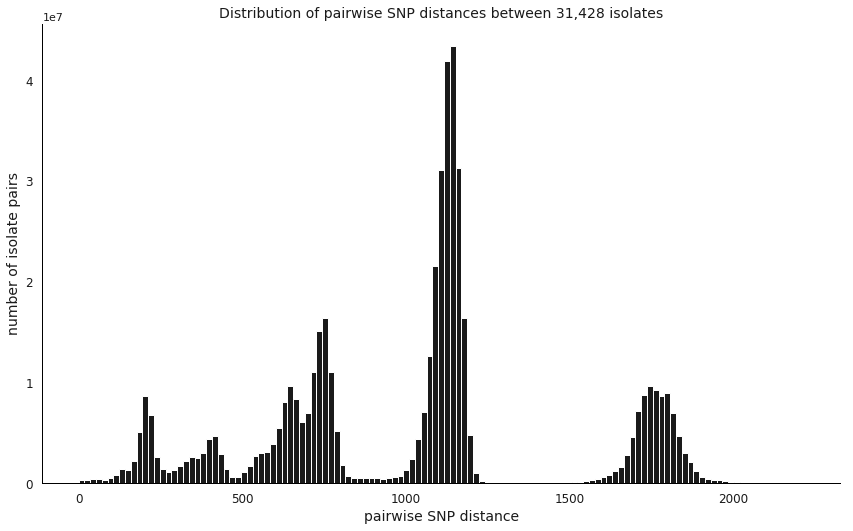

In [17]:
fig , ax = plt.subplots()

#SNP found in isolate denoted with a '1', sum across columns (isolates)
n , bins , patches = plt.hist(non_redundant_pairwise_SNP_dist_array , bins = 125 , color = 'k' , rwidth = 1.0 , edgecolor='white', linewidth=1.0)

plt.title('Distribution of pairwise SNP distances between 31,428 isolates', fontsize = 14, color = 'k')
plt.xlabel('pairwise SNP distance', fontsize = 14, color = 'k')
plt.ylabel('number of isolate pairs' , fontsize = 14, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)

ax.tick_params(labelcolor = 'k')

fig = plt.gcf()
fig.set_size_inches(12.0, 7.5)
fig.tight_layout()

plt.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
plt.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

### Within-Lineage variation

In [38]:
from pylab import plot, show, savefig, xlim, figure, hold, ylim, legend, boxplot, setp, axes

linewidth_for_box = 2.5

# function for setting the colors of the box plots pairs
def setBoxColors(bp , color):
    setp(bp['boxes'][0], color=color , linewidth = linewidth_for_box)
    setp(bp['caps'][0], color=color , linewidth = linewidth_for_box)
    setp(bp['caps'][1], color=color , linewidth = linewidth_for_box)
    setp(bp['whiskers'][0], color=color , linewidth = linewidth_for_box)
    setp(bp['whiskers'][1], color=color , linewidth = linewidth_for_box)
    setp(bp['fliers'][0], color=color)
    setp(bp['medians'][0], color='k' , linewidth = 2.0)
    bp['fliers'][0].set_markerfacecolor('white')
    bp['fliers'][0].set_markeredgewidth(0.4)
    bp['fliers'][0].set_markersize(6.0)
    bp['fliers'][0].set_markeredgecolor('k')
    bp['fliers'][0].set_alpha(0.7)
    
def plot_num_SNP_distances_btwn_lineages(pairwise_SNP_dist , global_lineage_i , global_lineage_j , color , x_pos):
    
    #make boxplot
    pairwise_SNP_distances = SNP_distances_for_pairs_in_lineages(global_lineage_i, global_lineage_j , pairwise_SNP_dist)
    bp = boxplot(pairwise_SNP_distances , positions = [ind[x_pos]], widths = box_width)
    setBoxColors(bp , color)
    
    return len(pairwise_SNP_distances)

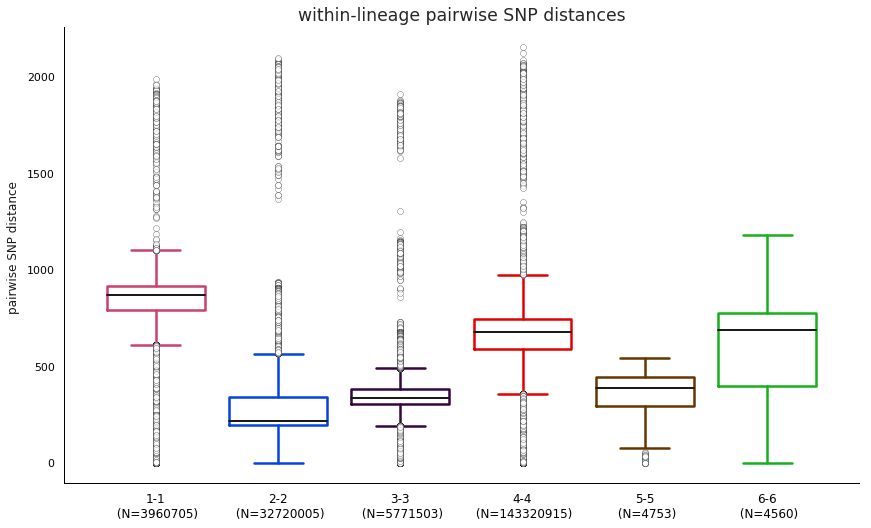

In [43]:
box_width = 0.8
ind = [1,2,3,4,5,6]
lineage_pairs = [['1','1'] , ['2','2'] , ['3','3'] , ['4','4'] , ['5','5'] , ['6','6']]

fig = plt.figure(1, figsize=(12, 7.5))
ax = axes()

num_isolate_pairs= []
x_pos = 0
for lineage_pair , color in zip( lineage_pairs , ['xkcd:dark pink', 'xkcd:blue', 'xkcd:dark purple', 'xkcd:red', 'xkcd:brown', 'xkcd:green'] ):
    
    #plot boxplot for lineage & store the number of isolates in sample
    num_isolate_pairs.append( plot_num_SNP_distances_btwn_lineages(pairwise_SNP_dist , lineage_pair[0] , lineage_pair[1] , color , x_pos) )
    x_pos += 1

#x-axis
xlim(0.25 , 6.75)

ax.set_xticks(ind)
ax.set_xticklabels([], rotation='horizontal', fontsize = 6)
x_labels = [lineage[0] + '-' + lineage[1] + '\n (N=' + str(num_isolates) + ')' for lineage , num_isolates in zip( lineage_pairs , num_isolate_pairs)]
ax.set_xticklabels(x_labels, rotation='horizontal', fontsize = 12)
ax.set_xlabel('')
ax.grid(False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.title('within-lineage pairwise SNP distances')

#label y-axis
fig.text(0.0, 0.53, 'pairwise SNP distance' ,  ha='center', va='center', rotation=90, fontsize = 12 , color = 'k')

fig = plt.gcf()
fig.tight_layout()

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelleft='on') # labels along the bottom edge are off

file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/within_global_lineage_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

### Between-Lineage variation

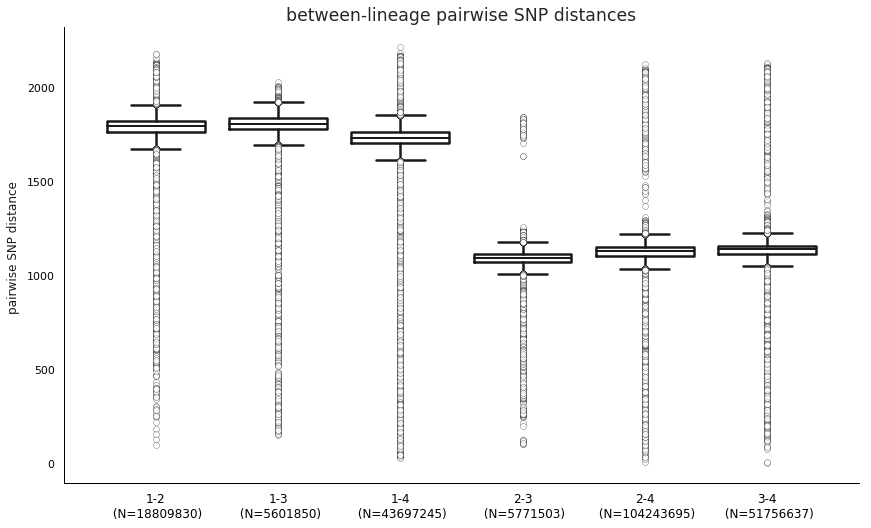

In [41]:
box_width = 0.8
ind = [1,2,3,4,5,6]
lineage_pairs = [['1','2'] , ['1','3'] , ['1','4'] , ['2','3'], ['2','4'], ['3','4']]

fig = plt.figure(1, figsize=(12, 7.5))
ax = axes()

num_isolate_pairs= []
x_pos = 0
for lineage_pair , color in zip( lineage_pairs , ['k', 'k', 'k', 'k', 'k', 'k'] ):
    
    #plot boxplot for lineage & store the number of isolates in sample
    num_isolate_pairs.append( plot_num_SNP_distances_btwn_lineages(pairwise_SNP_dist , lineage_pair[0] , lineage_pair[1] , color , x_pos) )
    x_pos += 1

#x-axis
xlim(0.25 , 6.75)

ax.set_xticks(ind)
ax.set_xticklabels([], rotation='horizontal', fontsize = 6)
x_labels = [lineage[0] + '-' + lineage[1] + '\n (N=' + str(num_isolates) + ')' for lineage , num_isolates in zip( lineage_pairs , num_isolate_pairs)]
ax.set_xticklabels(x_labels, rotation='horizontal', fontsize = 12)
ax.set_xlabel('')
ax.grid(False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.title('between-lineage pairwise SNP distances')

#label y-axis
fig.text(0.0, 0.53, 'pairwise SNP distance' ,  ha='center', va='center', rotation=90, fontsize = 12 , color = 'k')

fig = plt.gcf()
fig.tight_layout()

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelleft='on') # labels along the bottom edge are off

file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/between_global_lineage_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

####################################################################################################################################################################################

## [7] Re-calculate within-lineage pairwise SNP distances after dropping *mis-classified* isolates

####################################################################################################################################################################################

In [44]:
pairwise_SNP_dist

array([[   0,  606, 1139, ..., 1061,  174,  670],
       [ 606,    0, 1124, ..., 1036,  623,  645],
       [1139, 1124,    0, ..., 1035, 1152, 1177],
       ...,
       [1061, 1036, 1035, ...,    0, 1066, 1095],
       [ 174,  623, 1152, ..., 1066,    0,  683],
       [ 670,  645, 1177, ..., 1095,  683,    0]])

In [45]:
np.shape(pairwise_SNP_dist)

(31428, 31428)

In [46]:
isolate_annotation_DF.head()

,lineage_1,lineage_2,lineage_3,lineage_4,lineage_5,lineage_6,lineage_7,lineage_8,lineage_9,lineage_10,lineage_11,isolate_ID,lineage_call,group
0,4,2,1,2,1,1,i3,1,NaN,NaN,NaN,SAMEA3558733,4.2.1.2.1.1.i3.1,4B
1,4,2,1,2,2,1,1,NaN,NaN,NaN,NaN,SAMN03648641,4.2.1.2.2.1.1,4B
2,3,1,1,i1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMN03647419,3.1.1.i1,3
3,4,2,1,2,1,1,i1,NaN,NaN,NaN,NaN,SAMEA3671418,4.2.1.2.1.1.i1,4B
4,1,1,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMN07659096,1.1.1.2,1


In [47]:
np.shape(isolate_annotation_DF)

(31428, 14)

### Drop mis-classified isolates

isolates mis-classified from SNP barcode (visual inspection of phlogenies in Rectangular Tree Layout)

- L1: 3
    - SAMEA3445265
    - SAMEA1119746
    - SAMN06209986
        
- L2: 4
    - SAMEA3558144
    - SAMEA5366594
    - SAMEA5366622
    - SAMEA5366610
        
- L3: 2
    - SAMN02398716
    - SAMN08436122
        
- L4A: 1
    - SAMEA3359387
    
-  L4B: 0
    
- L4C: 4
    - SAMEA2783243
    - SAMN07236506
    - SAMEA104153428
    - SAMEA961670
    
- L5: 0
    
- L6: 0

In [64]:
misclassified_isolates_list = ['SAMEA3445265','SAMEA1119746','SAMN06209986','SAMEA3558144','SAMEA5366594','SAMEA5366622','SAMEA5366610','SAMN02398716','SAMN08436122','SAMEA3359387','SAMEA2783243','SAMN07236506','SAMEA104153428','SAMEA961670']

In [65]:
isolate_annotation_DF[[(isolate_id in misclassified_isolates_list) for isolate_id in isolate_annotation_DF.isolate_ID]]

,lineage_1,lineage_2,lineage_3,lineage_4,lineage_5,lineage_6,lineage_7,lineage_8,lineage_9,lineage_10,lineage_11,isolate_ID,lineage_call,group
780,3,1,1,i1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMN08436122,3.1.1.i1,3
2658,4,2,1,1,1,2,2,1,NaN,NaN,NaN,SAMN07236506,4.2.1.1.1.2.2.1,4C
4344,4,2,1,1,1,2,2,2,NaN,NaN,NaN,SAMEA961670,4.2.1.1.1.2.2.2,4C
5734,4,2,1,1,1,2,2,1,NaN,NaN,NaN,SAMEA2783243,4.2.1.1.1.2.2.1,4C
12056,4,1,i1,2,1,NaN,NaN,NaN,NaN,NaN,NaN,SAMEA3359387,4.1.i1.2.1,4A
14504,1,2,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,SAMN06209986,1.2.1.1.1,1
17407,1,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMEA3445265,1.2.2.2,1
23065,4,2,1,1,1,2,2,1,NaN,NaN,NaN,SAMEA104153428,4.2.1.1.1.2.2.1,4C
23426,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMEA5366622,2.1,2
24095,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMEA3558144,2.2.2,2


#### Filter out isolates from pairwise SNP distance matrix & isolate annotation DF

In [66]:
misclassified_isolates_filter = np.array([(isolate_id not in misclassified_isolates_list) for isolate_id in isolate_annotation_DF.isolate_ID])

#drop isolates from isolate annotation DF
isolate_annotation_DF = isolate_annotation_DF[missclassified_isolates_filter]
isolate_annotation_DF.reset_index(inplace = True, drop = True)

#slice out the rows that correspond to mis-classified isolates
pairwise_SNP_dist = pairwise_SNP_dist[misclassified_isolates_filter , :]

#slice out the columns that correspond to mis-classified isolates
pairwise_SNP_dist = pairwise_SNP_dist[: , misclassified_isolates_filter]

In [67]:
pairwise_SNP_dist

array([[   0,  606, 1139, ..., 1061,  174,  670],
       [ 606,    0, 1124, ..., 1036,  623,  645],
       [1139, 1124,    0, ..., 1035, 1152, 1177],
       ...,
       [1061, 1036, 1035, ...,    0, 1066, 1095],
       [ 174,  623, 1152, ..., 1066,    0,  683],
       [ 670,  645, 1177, ..., 1095,  683,    0]])

In [68]:
np.shape(pairwise_SNP_dist)

(31414, 31414)

In [69]:
isolate_annotation_DF.head()

,lineage_1,lineage_2,lineage_3,lineage_4,lineage_5,lineage_6,lineage_7,lineage_8,lineage_9,lineage_10,lineage_11,isolate_ID,lineage_call,group
0,4,2,1,2,1,1,i3,1,NaN,NaN,NaN,SAMEA3558733,4.2.1.2.1.1.i3.1,4B
1,4,2,1,2,2,1,1,NaN,NaN,NaN,NaN,SAMN03648641,4.2.1.2.2.1.1,4B
2,3,1,1,i1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMN03647419,3.1.1.i1,3
3,4,2,1,2,1,1,i1,NaN,NaN,NaN,NaN,SAMEA3671418,4.2.1.2.1.1.i1,4B
4,1,1,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SAMN07659096,1.1.1.2,1


In [70]:
np.shape(isolate_annotation_DF)

(31414, 14)

#### Use upper-triangular indices to get non-redundant array of pairwise SNP distances between all isolates

In [71]:
num_isolates = np.shape(isolate_annotation_DF)[0]
upper_triangle_indices = np.triu_indices(n = num_isolates , k = 1)

non_redundant_pairwise_SNP_dist_array = pairwise_SNP_dist[upper_triangle_indices]

In [72]:
non_redundant_pairwise_SNP_dist_array

array([ 606, 1139,  406, ..., 1066, 1095,  683])

In [73]:
len(non_redundant_pairwise_SNP_dist_array)

493403991

#### Maximum SNP distance between two isolates?

In [74]:
np.max(non_redundant_pairwise_SNP_dist_array) #max SNP distance between isolates

2165

In [75]:
np.where(pairwise_SNP_dist == 2165)

(array([15234, 29108]), array([29108, 15234]))

In [76]:
isolate_annotation_DF.loc[15234,['lineage_call','isolate_ID']]

lineage_call               6
isolate_ID      SAMN02231115
Name: 15234, dtype: object

In [77]:
isolate_annotation_DF.loc[29108,['lineage_call','isolate_ID']]

lineage_call       1.1.1.1.1
isolate_ID      SAMN07236475
Name: 29108, dtype: object

In [78]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=3
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.rcParams['axes.grid']=True
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 12})

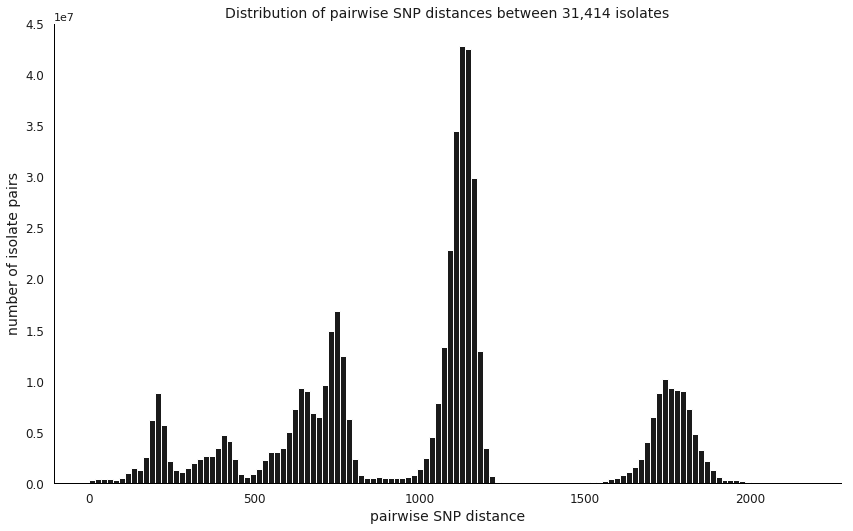

In [80]:
fig , ax = plt.subplots()

#SNP found in isolate denoted with a '1', sum across columns (isolates)
n , bins , patches = plt.hist(non_redundant_pairwise_SNP_dist_array , bins = 120 , color = 'k' , rwidth = 1.0 , edgecolor='white', linewidth=1.0)

plt.title('Distribution of pairwise SNP distances between 31,414 isolates', fontsize = 14, color = 'k')
plt.xlabel('pairwise SNP distance', fontsize = 14, color = 'k')
plt.ylabel('number of isolate pairs' , fontsize = 14, color = 'k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)

ax.tick_params(labelcolor = 'k')

fig = plt.gcf()
fig.set_size_inches(12.0, 7.5)
fig.tight_layout()

plt.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
plt.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

#### Define a function that takes in the (distance matrix), (global lineage i) and (global lineage j) and returns an array of the pairwise SNP distances for all isolate pairs *between* those lineages

In [81]:
def SNP_distances_for_pairs_in_lineages(global_lineage_i, global_lineage_j , pairwise_SNP_dist_matrix):
    
    #get a filter for rows for isolates that belong to specific global lineage i
    global_lineage_filter_i = np.array(isolate_annotation_DF.lineage_1 == global_lineage_i)
    
    #get a filter for columns for isolates that belong to specific global lineage j
    global_lineage_filter_j = np.array(isolate_annotation_DF.lineage_1 == global_lineage_j)
    
    #slice out the rows that correspond to isolates that belong to global lineage i
    pairwise_SNP_dist_for_global_lineages = pairwise_SNP_dist[global_lineage_filter_i , :]
    
    #slice out the columns that correspond to isolates that belong to global lineage j
    pairwise_SNP_dist_for_global_lineages = pairwise_SNP_dist_for_global_lineages[: , global_lineage_filter_j]
    
    #get the indices for the upper triangular portion of the matrix to get non-redundant array of SNP distances
    num_isolates_lineage_i = np.shape(pairwise_SNP_dist_for_global_lineages)[0]
    num_isolates_lineage_j = np.shape(pairwise_SNP_dist_for_global_lineages)[1]
    
    upper_triangle_indices = np.triu_indices(n = num_isolates_lineage_i , k = 1 , m = num_isolates_lineage_j)

    non_redundant_pairwise_SNP_dist_array = pairwise_SNP_dist_for_global_lineages[upper_triangle_indices]
    
    return non_redundant_pairwise_SNP_dist_array

#### Define a function that creates a histogram of all pairwise SNP distances between two global lineages (lineage i) and (lineage j)

In [82]:
def histogram_of_pairwise_distances(global_lineage_i, global_lineage_j):
    
    #get pairwise SNP distances between all isolates in lienage i and lineage j
    non_redundant_pairwise_SNP_dist_array = SNP_distances_for_pairs_in_lineages(global_lineage_i, global_lineage_j, pairwise_SNP_dist)

    fig , ax = plt.subplots()

    n , bins , patches = plt.hist(non_redundant_pairwise_SNP_dist_array , bins = 90 , color = 'k' , rwidth = 1.0 , edgecolor='white', linewidth=1.0)

    plt.title('Distribution of pairwise SNP distances between Lineages ' + global_lineage_i + ' and ' + global_lineage_j, fontsize = 12, color = 'k')
    plt.xlabel('pairwise SNP distance', fontsize = 12, color = 'k')
    plt.ylabel('number of isolate pairs' , fontsize = 12, color = 'k')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(False)

    ax.tick_params(labelcolor = 'k')

    fig = plt.gcf()
    fig.set_size_inches(9.0, 5.25)
    fig.tight_layout()

    plt.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
    plt.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

    plt.show()

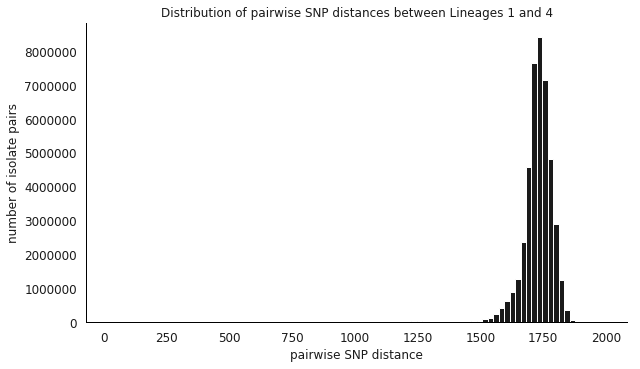

In [83]:
histogram_of_pairwise_distances('1', '4')

### Within-Lineage variation

In [92]:
from pylab import plot, show, savefig, xlim, figure, hold, ylim, legend, boxplot, setp, axes

linewidth_for_box = 2.5

# function for setting the colors of the box plots pairs
def setBoxColors(bp , color):
    setp(bp['boxes'][0], color=color , linewidth = linewidth_for_box)
    setp(bp['caps'][0], color=color , linewidth = linewidth_for_box)
    setp(bp['caps'][1], color=color , linewidth = linewidth_for_box)
    setp(bp['whiskers'][0], color=color , linewidth = linewidth_for_box)
    setp(bp['whiskers'][1], color=color , linewidth = linewidth_for_box)
    setp(bp['fliers'][0], color=color)
    setp(bp['medians'][0], color='k' , linewidth = 2.0)
    bp['fliers'][0].set_markerfacecolor('white')
    bp['fliers'][0].set_markeredgewidth(0.4)
    bp['fliers'][0].set_markersize(6.0)
    bp['fliers'][0].set_markeredgecolor('k')
    bp['fliers'][0].set_alpha(0.7)
    
def plot_num_SNP_distances_btwn_lineages(pairwise_SNP_dist , global_lineage_i , global_lineage_j , color , x_pos):
    
    #make boxplot
    pairwise_SNP_distances = SNP_distances_for_pairs_in_lineages(global_lineage_i, global_lineage_j , pairwise_SNP_dist)
    median_pairwise_SNP_distance = np.median(pairwise_SNP_distances) #get median
    bp = boxplot(pairwise_SNP_distances , positions = [ind[x_pos]], widths = box_width)
    setBoxColors(bp , color)
    
    return [len(pairwise_SNP_distances) , int(median_pairwise_SNP_distance)]

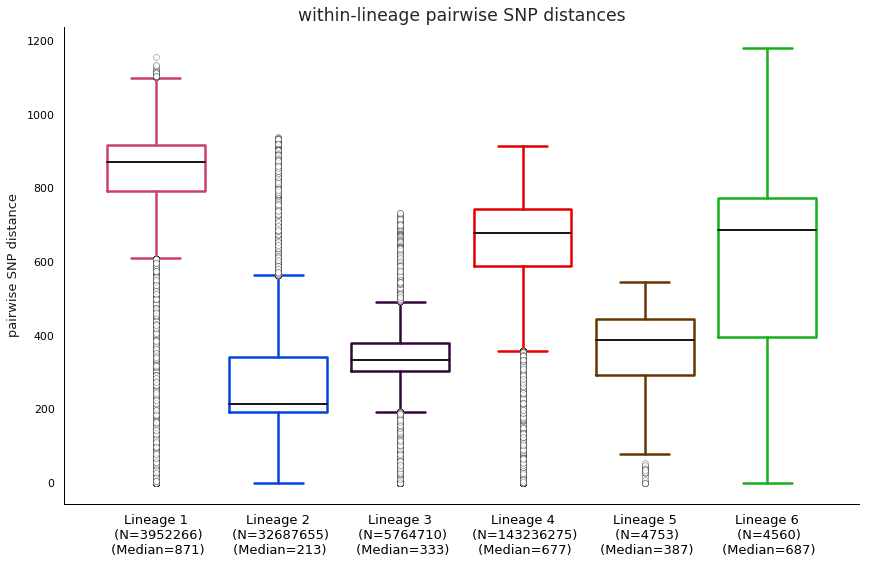

In [94]:
box_width = 0.8
ind = [1,2,3,4,5,6]
lineage_pairs = [['1','1'] , ['2','2'] , ['3','3'] , ['4','4'] , ['5','5'] , ['6','6']]

fig = plt.figure(1, figsize=(12, 8.0))
ax = axes()

num_isolate_pairs_list = []
median_pairwise_SNP_dist_list = []
x_pos = 0
for lineage_pair , color in zip( lineage_pairs , ['xkcd:dark pink', 'xkcd:blue', 'xkcd:dark purple', 'xkcd:red', 'xkcd:brown', 'xkcd:green'] ):
    
    #plot boxplot for lineage & store the number of isolates in sample
    num_isolate_pairs_compared , median_pairwise_SNP_dist = plot_num_SNP_distances_btwn_lineages(pairwise_SNP_dist , lineage_pair[0] , lineage_pair[1] , color , x_pos)
    num_isolate_pairs_list.append( num_isolate_pairs_compared )
    median_pairwise_SNP_dist_list.append( median_pairwise_SNP_dist )
    x_pos += 1

#x-axis
xlim(0.25 , 6.75)

ax.set_xticks(ind)
ax.set_xticklabels([], rotation='horizontal', fontsize = 6)
x_labels = ['Lineage ' + lineage[0] + '\n (N=' + str(num_isolates) + ')' + '\n (Median=' + str(median_dist) + ')' for lineage , num_isolates , median_dist in zip( lineage_pairs , num_isolate_pairs_list , median_pairwise_SNP_dist_list)]
ax.set_xticklabels(x_labels, rotation='horizontal', fontsize = 13)
ax.set_xlabel('')
ax.grid(False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.title('within-lineage pairwise SNP distances')

#label y-axis
fig.text(0.0, 0.53, 'pairwise SNP distance' ,  ha='center', va='center', rotation=90, fontsize = 13 , color = 'k')

fig = plt.gcf()
fig.tight_layout()

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelleft='on') # labels along the bottom edge are off

file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/within_global_lineage_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()